Read the image, then calculate the number of pixels corresponding to different structures. Identify the image with the largest aneurysm, the image with the largest connected region, and the image with the largest total area.

In [ ]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define folder path
folder_path = r"C:\Users\邱宇辰\OneDrive - Universiteit Utrecht\桌面\Utrecht studying\Team challenge\Aneurysm_TC_data\saved_images"

# Define color ranges (in RGB format)
red_color = np.array([255, 0, 0])
green_color = np.array([0, 128, 0])
blue_color = np.array([0, 0, 255])

# Define color tolerance
tolerance = 50

def count_pixels_by_color(image, target_color, tolerance):
    """Use NumPy to count the number of pixels of a specified color in an image"""
    image_array = np.array(image)  # Convert the image to a NumPy array
    color_diff = np.abs(image_array - target_color)  # Calculate color differences
    within_tolerance = np.all(color_diff <= tolerance, axis=-1)  # Check if within tolerance range
    return np.sum(within_tolerance)  # Return the number of pixels that match

# Initialize variables to store maximum values and corresponding filenames
max_connection_region_pixels = 0
max_connection_region_file = None

max_aneurysm_pixels = 0
max_aneurysm_file = None

max_connection_region_aneurysm_pixels = 0
max_connection_region_aneurysm_file = None

# Open file to save intermediate results
with open(os.path.join(folder_path, 'results.txt'), 'w') as result_file:
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if '2d_projection' in filename and filename.endswith('.png'):
            file_path = os.path.join(folder_path, filename)
            image = Image.open(file_path).convert('RGB')
            
            # Count pixel areas
            blood_vessel_pixels = count_pixels_by_color(image, red_color, tolerance)
            connection_region_pixels = count_pixels_by_color(image, green_color, tolerance)
            aneurysm_pixels = count_pixels_by_color(image, blue_color, tolerance)
            
            # Write results to the file
            result_file.write(f"File: {filename}\n")
            result_file.write(f"blood_vessel_pixels: {blood_vessel_pixels}\n")
            result_file.write(f"connection_region_pixels: {connection_region_pixels}\n")
            result_file.write(f"aneurysm_pixels: {aneurysm_pixels}\n")
            result_file.write("-" * 30 + "\n")

            # Compare connection_region_pixels count
            if connection_region_pixels > max_connection_region_pixels:
                max_connection_region_pixels = connection_region_pixels
                max_connection_region_file = filename
            
            # Compare aneurysm_pixels count
            if aneurysm_pixels > max_aneurysm_pixels:
                max_aneurysm_pixels = aneurysm_pixels
                max_aneurysm_file = filename
            
            # Compare the sum of aneurysm_pixels and connection_region_pixels
            connection_region_aneurysm_pixels = connection_region_pixels + aneurysm_pixels
            if connection_region_aneurysm_pixels > max_connection_region_aneurysm_pixels:
                max_connection_region_aneurysm_pixels = connection_region_aneurysm_pixels
                max_connection_region_aneurysm_file = filename

# Output final results
print("\nResults:")
print(f"Image with most connection_region pixels: {max_connection_region_file} (connection_region_pixels: {max_connection_region_pixels})")
print(f"Image with most aneurysm pixels: {max_aneurysm_file} (aneurysm_pixels: {max_aneurysm_pixels})")
print(f"Image with most connection_region and aneurysm pixels combined: {max_connection_region_aneurysm_file} (connection_region and aneurysm pixels: {max_connection_region_aneurysm_pixels})")



Results:
Image with most connection_region pixels: 2d_projection_360.png (connection_region_pixels: 47827)
Image with most aneurysm pixels: 2d_projection_250.png (aneurysm_pixels: 165492)
Image with most connection_region and aneurysm pixels combined: 2d_projection_250.png (connection_region and aneurysm pixels: 196882)


Display the selected images

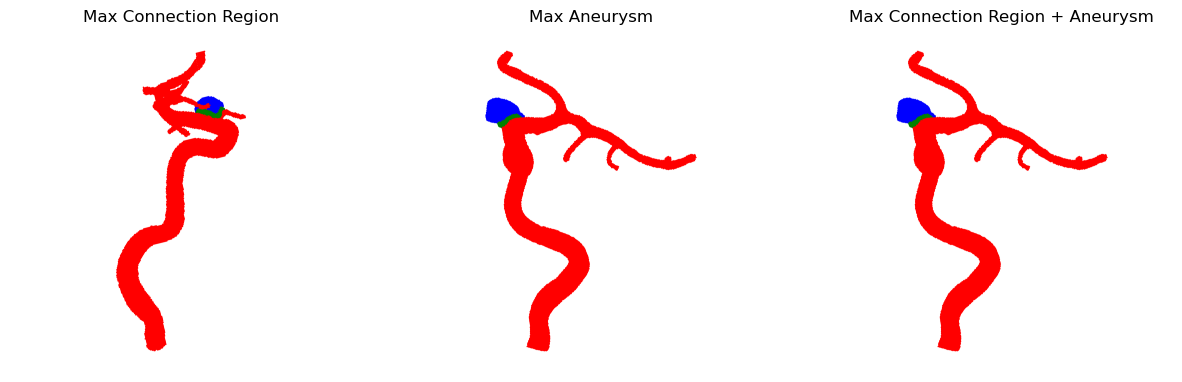

In [ ]:
from matplotlib import image as mpimg

# Construct the full file paths using os.path.join
max_connection_region_path = os.path.join(folder_path, max_connection_region_file)
max_aneurysm_path = os.path.join(folder_path, max_aneurysm_file)
max_connection_region_aneurysm_path = os.path.join(folder_path, max_connection_region_aneurysm_file)

# Use mpimg.imread to read the images
max_connection_region = mpimg.imread(max_connection_region_path)
max_aneurysm = mpimg.imread(max_aneurysm_path)
max_connection_region_aneurysm = mpimg.imread(max_connection_region_aneurysm_path)

# Display the images using matplotlib
plt.figure(figsize=(15, 5))  

plt.subplot(1, 3, 1)
plt.imshow(max_connection_region)
plt.title("Max Connection Region")
plt.axis("off")  

plt.subplot(1, 3, 2)
plt.imshow(max_aneurysm)
plt.title("Max Aneurysm")
plt.axis("off")  

plt.subplot(1, 3, 3)
plt.imshow(max_connection_region_aneurysm)
plt.title("Max Connection Region + Aneurysm")
plt.axis("off")  

plt.show()


Used to check the RGB values of different colors in the image to fix errors. (Previously, there was a problem in the RGB value, this code is used to fix problem )

In [1]:
from PIL import Image
import numpy as np

# Set the image path
image_path = r"C:\Users\邱宇辰\OneDrive - Universiteit Utrecht\桌面\Utrecht studying\Team challenge\Aneurysm_TC_data\saved_images2\2d_projection_0.png"

# Read the image and convert it to a NumPy array
img = Image.open(image_path).convert("RGB")
img_array = np.array(img)

# Get all unique colors and their pixel counts
unique_colors, counts = np.unique(img_array.reshape(-1, 3), axis=0, return_counts=True)

# Sort by pixel count in descending order
sorted_indices = np.argsort(counts)[::-1]

# Output the top four colors and their corresponding pixel counts
print("Top four color values and their pixel counts in the image:")
for i in range(min(4, len(unique_colors))):
    color = unique_colors[sorted_indices[i]]
    count = counts[sorted_indices[i]]
    print(f"Color {tuple(color)}: {count} pixels")



Top four color values and their pixel counts in the image:
Color (255, 255, 255): 29031474 pixels
Color (255, 0, 0): 2195039 pixels
Color (0, 0, 255): 67365 pixels
Color (0, 128, 0): 41379 pixels
